# Multilayer Tidal Calculations
In this cookbook we will explore how we can use TidalPy's multilayer tidal functions to calculate tidal heating as a function of radius.

**References**:
- SVC16 : Sabadini, Vermeerson, & Cambiotti (2016), DOI: [10.1007/978-94-017-7552-6](https://doi.org/10.1007/978-94-017-7552-6).
- HH14  : Henning & Hurford (2014), DOI: [10.1088/0004-637X/789/1/30](https://doi.org/10.1088/0004-637X/789/1/30).
- TB05  : Tobie et al. (2005), DOI: [10.1016/j.icarus.2005.04.006](https://doi.org/10.1016/j.icarus.2005.04.006).
- S74   : Saito (1974), DOI: [10.4294/jpe1952.22.123](https://doi.org/10.4294/jpe1952.22.123).
- TS72  : Takeuchi & Saito (1972), DOI: [10.1016/B978-0-12-460811-5.50010-6](http://dx.doi.org/10.1016/B978-0-12-460811-5.50010-6).
- M16   : Martens (2016, [PhD Thesis](https://resolver.caltech.edu/CaltechTHESIS:04102016-211741759)), DOI: [10.7907/Z9N29TX7](http://dx.doi.org/10.7907/Z9N29TX7).
- ID    : [IcyDwarf Code](https://github.com/MarcNeveu/IcyDwarf/blob/master/IcyDwarf/Thermal.h) written by Marc Neveu.

## Build a Planet
For this example we will use the Io-Jupiter system.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
# %matplotlib ipympl
np.seterr(divide='ignore')
from TidalPy.structures import build_world
from TidalPy.utilities.conversions import orbital_motion2semi_a
from TidalPy.utilities.numpy_helper import find_nearest
from TidalPy.rheology.complex_compliance.compliance_models import maxwell, sundberg
from TidalPy.tides.potential import tidal_potential_simple, tidal_potential_nsr

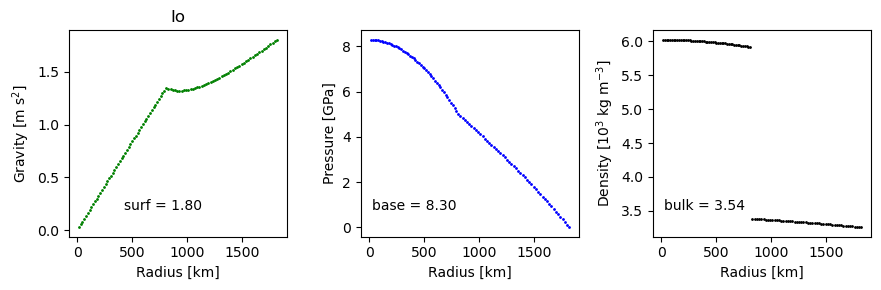

In [2]:
io = build_world('Io')
io.paint()
jupiter = build_world('Jupiter')
tidal_host_mass = jupiter.mass
eccentricity = 0.41
orbital_freq = 2. * np.pi / (86400. * 1.76914)
# orbital_freq = 2. * np.pi / (86400. * 1.)
orbital_period = 2. * np.pi / orbital_freq
spin_rate = 1.0 * orbital_freq
periapsis = 0.0
obliquity = np.radians(30.)
semi_major_axis = orbital_motion2semi_a(orbital_freq, tidal_host_mass, io.mass)

# Other global switches
use_simple_potential = False

# We won't be using TidalPy's OOP approach (which currently does not use the multilayer approach,
#    instead relying on a homogenous model broken up by layers), instead we will pull out a few parameters needed
#    for the multilayer calculations.
radius_array = io.radii
surf_area_array = io.surface_areas
volume_array = io.volume_slices
# Depth array skips the first shell since most viscoelastic properties are not defined there.
depth_array = (io.radius - radius_array)
gravity_array = io.gravities
density_array = io.densities
pressure_array = io.pressures

# We will give the core and mantle a different viscoelastic state, but to do that we need to know what index
#   corresponds to the top of the core.
core_radius = io.core.radius
core_index = radius_array <= core_radius
mantle_index = radius_array > core_radius
mantle_N = len(radius_array[mantle_index])
core_N = len(radius_array[core_index])
total_N = len(radius_array)

# Determine some global properties
world_radius = io.radius
world_surf_area = io.surface_area
surface_gravity = io.gravity_surface
world_bulk_density = io.density_bulk
mantle_bulk_density = np.average(density_array[mantle_index])

# Setup Io's viscoelastic state - this is not particularly accurate ans is just meant for demonstration purposes.
# All of the viscoelastic properties are not defined at r=0, so we are skipping the inner-most shell. This is done through
#    the "len(radius_array) - 1"
rheo_func = maxwell
# We will not be looking at bulk modulus dissipation. So, the bulk modulus will only effect the compressibility results
#    calculated with the
bulk_modulus_array = 100.0e9 * np.ones_like(radius_array)
bulk_modulus_array[core_index] = 200.0e9

# Shear modulus and viscosity is much more important, but to keep this example simple we will assume a
#   constant shear and an increasing viscosity towards the surface
shear_modulus_array = np.zeros_like(radius_array) # Very small shear to mimic liquid layer.
shear_modulus_array[mantle_index] = 50.0e9

viscosity_array = 1.e1 * np.ones_like(radius_array)
viscosity_array[mantle_index] = np.logspace(23, 15, mantle_N)

# Now we can calculate the complex_compliance of the world. We will just use a Maxwell model here but several
#    others are available.
complex_compliance_array = np.zeros_like(radius_array, dtype=np.complex128)
complex_compliance_array[mantle_index] = rheo_func(orbital_freq,
                                                        shear_modulus_array[mantle_index]**(-1),
                                                        viscosity_array[mantle_index])
complex_shear_array = np.zeros_like(radius_array, dtype=np.complex128)
complex_shear_array[mantle_index] = complex_compliance_array[mantle_index]**(-1)

In [3]:
# Set this variable to True to restrict the dissipation calculations to just the mantle.
#    This tends to produce better results for the propagation matrix method, but should be set to False for the shooting method.
restrict_propagation_to_mantle = False

if restrict_propagation_to_mantle:
    core_R = None
    radii = radius_array[mantle_index]
    surf_areas = surf_area_array[mantle_index]
    volumes = volume_array[mantle_index]
    depths = depth_array[mantle_index]
    gravitys = gravity_array[mantle_index]
    densitys = density_array[mantle_index]
    pressures = pressure_array[mantle_index]
    viscosities = viscosity_array[mantle_index]
    complex_compliances = complex_compliance_array[mantle_index]
    complex_shears = complex_shear_array[mantle_index]
    shear_moduli = shear_modulus_array[mantle_index]
    bulk_moduli = bulk_modulus_array[mantle_index]
else:
    core_R = core_radius
    radii = radius_array
    surf_areas = surf_area_array
    volumes = volume_array
    depths = depth_array
    gravitys = gravity_array
    densitys = density_array
    pressures = pressure_array
    viscosities = viscosity_array
    complex_compliances = complex_compliance_array
    complex_shears = complex_shear_array
    shear_moduli = shear_modulus_array
    bulk_moduli = bulk_modulus_array

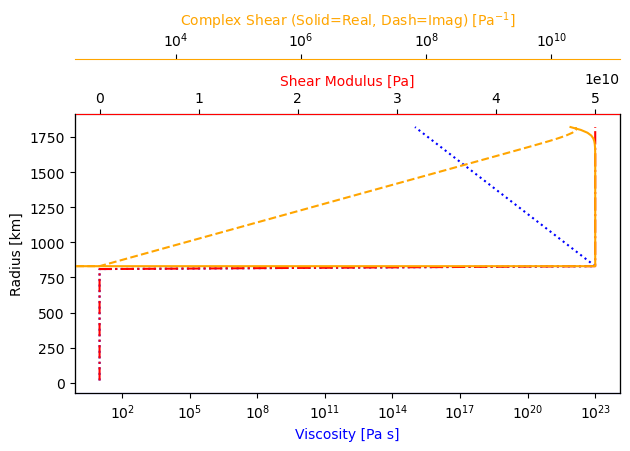

In [4]:
# Now let's see what this looks like
fig_visco, ax_visco = plt.subplots()
ax_shear = ax_visco.twiny()
ax_comp = ax_visco.twiny()
ax_comp.spines["top"].set_position(("axes", 1.2))

ax_visco.plot(viscosities, radii/1000., c='b', ls=':')
ax_shear.plot(shear_moduli, radii/1000., c='r', ls='-.')
ax_comp.plot(np.real(complex_shears), radii/1000., c='orange', ls='-')
ax_comp.plot(np.imag(complex_shears), radii/1000., c='orange', ls='--')

ax_visco.set(ylabel='Radius [km]', xlabel='Viscosity [Pa s]', xscale='log')
ax_shear.set(xlabel='Shear Modulus [Pa]', xscale='linear')
ax_comp.set(xlabel='Complex Shear (Solid=Real, Dash=Imag) [Pa$^{-1}$]', xscale='log')
for ax, color in zip([ax_visco, ax_shear, ax_comp], ['b', 'r', 'orange']):
    if ax is ax_visco:
        ax.spines['bottom'].set_color(color)
    else:
        ax.spines['top'].set_color(color)
    ax.xaxis.label.set_color(color)

fig_visco.tight_layout()
plt.show()

## Calculate the multilayer tidal response using a propagation matrix technique
TidalPy offers both a propagation matrix (HH14, SVC16, ID) and a shooting method technique (TS72, S74, TB05, M16) to calculate dissipation vs. radius.
The propagation matrix assumes incompressibility and does not allow for dynamic tides. Nor can it fully capture the propagation across liquid layers without some hacks (e.g., assume shear modulus is very small rather than zero).
The shooting method allows us the model all of the above with the addition of (since compressibility is allowed) including bulk dissipation (`Im[bulk_modulus] != 0`).
There are a few drawbacks with the current TidalPy implementation:
- Numerical stability when allowing for dynamic tides in liquid layers. Certain choices of forcing frequency can lead to numerical problems within liquid layers that can then affect other layers. If you are using liquid layers it is reccomended to turn dynamic tides off (you can leave them on in the solid layers), or if you must use dynamic tides then perform extensive testing to ensure the problem has correctly converged.
- Slow performance. Even though TidalPy utilizes JIT compiled functions, there are some aspects of the numerical shooting method that still (as of this version) utilize non-compiled python leading to slower performance. Even without these issues, the shooting method is still performing 1--3 numerical integrations per layer. If you are using this during a time integration, *especially* if considering multiple tidal modes, then calculations can slow down pretty dramatically.
    - A future version of TidalPy will offer pre-calculated lookup tables to try and mitigate this problem at the cost of a slight loss in accuracy (TODO).

In [5]:
# Load TidalPy's multilayer functions
from TidalPy.radial_solver import find_love, radial_solver
from TidalPy.radial_solver.matrix import fundamental_matrix_orderl2, propagate
from TidalPy.tides.multilayer.stress_strain import calculate_strain_stress
from TidalPy.tides.modes.multilayer_modes import collapse_multilayer_modes

### Calculate Radial Functions

In [6]:
use_shooting_method = True

if use_shooting_method:
    # Use the numerical shooting method technique.
    if restrict_propagation_to_mantle:
        # Use a homogeneous shooting function.
        tidal_y = \
            radial_solver(
                radii, complex_shears, bulk_moduli,
                densitys, gravitys, orbital_freq, world_bulk_density,
                is_solid_by_layer=[True], is_static_by_layer=[True], indices_by_layer=[mantle_index],
                order_l=2,
                surface_boundary_condition=None,
                use_kamata=False, verbose=False,
                integrator='scipy', integration_method='RK45',
                integration_rtol=1.0e-6, integration_atol=1.0e-8,
                nondimensionalize=True)
    else:
        # Use a liquid layer -> solid layer shooting function.
        tidal_y = \
            radial_solver(
                radii, complex_shears, bulk_moduli,
                densitys, gravitys, orbital_freq, world_bulk_density,
                is_solid_by_layer=[False, True], is_static_by_layer=[True, True], indices_by_layer=[core_index, mantle_index],
                order_l=2,
                surface_boundary_condition=None,
                use_kamata=False, verbose=False,
                integrator='scipy', integration_method='RK45',
                integration_rtol=1.0e-6, integration_atol=1.0e-8,
                nondimensionalize=True)

    # Calculate parameters not found in the functions above
    k2, h2, l2 = tidal_y[4, :] - 1., tidal_y[0, :] * gravitys, tidal_y[2, :] * gravitys
    
else:
    # Use the propagation matrix technique.
    # Find the fundamental matrix; skip the innermost shell as that will be a boundary condition.
    Y, Y_inv, derivative_mtx = fundamental_matrix_orderl2(radii, complex_shears, densitys, gravitys)

    # Propagate the tidal solution through the world's shells
    central_boundary_condition = np.zeros((6, 3), dtype=np.complex128)
    # Roberts & Nimmo (2008): Liquid innermost zone.
    central_boundary_condition[0, 0] = 0.05 + 0.0j
    central_boundary_condition[1, 1] = 0.01 + 0.0j
    central_boundary_condition[5, 2] = 1.0 + 0.0j

    tidal_y, tidal_y_derivative = propagate(Y, Y_inv, derivative_mtx, central_boundary_condition, world_radius, order_l=2)

    # Decompose the tidal solution into useful properties
    #    There is a gradient in this function so we lose another shell. Thus the [1:] in viscoelastic properties
    k2, h2, l2 = find_love(tidal_y, gravitys[-1])


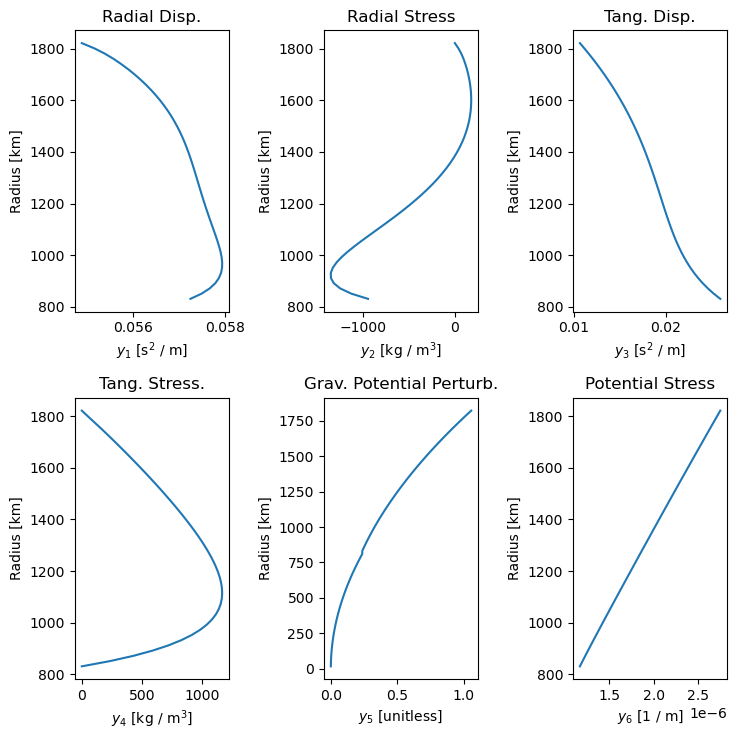

In [7]:
from TidalPy.utilities.graphics.multilayer import yplot

_ = yplot(tidal_y, radii)

Surface Love & Shida Numbers
k_2 = 5.47e-02-1.26e-03j
h_2 = 9.90e-02-1.86e-03j
l_2 = 1.93e-02-4.88e-04j


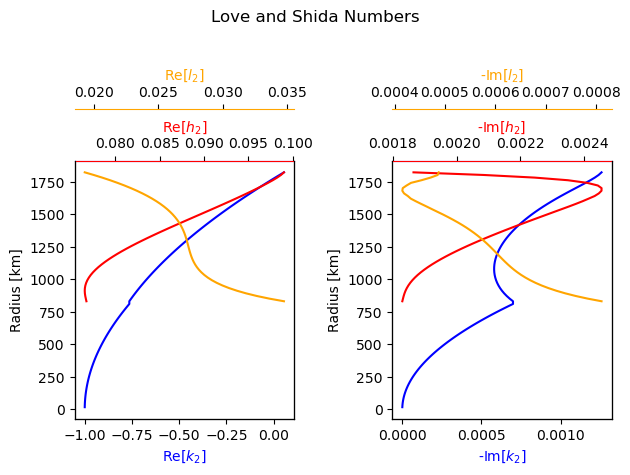

In [8]:
print('Surface Love & Shida Numbers')
print(f'k_2 = {k2[-1]:.2e}\nh_2 = {h2[-1]:.2e}\nl_2 = {l2[-1]:.2e}')

# Let's plot these as a function of depth.
fig_love, love_axes = plt.subplots(ncols=2)
fig_love.suptitle('Love and Shida Numbers')

for ax_i, ax in enumerate(love_axes):
    ax_love_h = ax.twiny()
    ax_love_l = ax.twiny()
    ax_love_l.spines["top"].set_position(("axes", 1.2))
    
    if ax_i == 0:
        ax.plot(np.real(k2), radii/1000., c='b', ls='-')
        ax_love_h.plot(np.real(h2), radii/1000., c='r', ls='-')
        ax_love_l.plot(np.real(l2), radii/1000., c='orange', ls='-')
        
        ax.set(ylabel='Radius [km]', xlabel='Re[$k_{2}$]', xscale='linear')
        ax_love_h.set(xlabel='Re[$h_{2}$]', xscale='linear')
        ax_love_l.set(xlabel='Re[$l_{2}$]', xscale='linear')
    else:
        ax.plot(-np.imag(k2), radii/1000., c='b', ls='-')
        ax_love_h.plot(-np.imag(h2), radii/1000., c='r', ls='-')
        ax_love_l.plot(-np.imag(l2), radii/1000., c='orange', ls='-')

        ax.set(ylabel='Radius [km]', xlabel='-Im[$k_{2}$]', xscale='linear')
        ax_love_h.set(xlabel='-Im[$h_{2}$]', xscale='linear')
        ax_love_l.set(xlabel='-Im[$l_{2}$]', xscale='linear')

    for ax2, color in zip([ax, ax_love_h, ax_love_l], ['b', 'r', 'orange']):
        if ax2 is ax_visco:
            ax2.spines['bottom'].set_color(color)
        else:
            ax2.spines['top'].set_color(color)
        ax2.xaxis.label.set_color(color)

fig_love.tight_layout()
plt.show()

## Calculate Tidal Displacement
Utilizing the simplified tidal potential (low eccentricity, no obliquity, spin-synchronous).

In [9]:
# Define latitude and longitude domain
colatitude = np.linspace(0.1, 179.9, 35)
latitude = colatitude - 90.
longitude = np.linspace(0., 360., 30)
longitude_r = np.radians(longitude)
colatitude_r = np.radians(colatitude)
time_domain = np.linspace(0., orbital_period, 100)

long_mtx, lat_mtx, time_mtx = \
    np.meshgrid(longitude_r, colatitude_r, time_domain, indexing='ij')

# Calculate the simplified tidal potential
if use_simple_potential:
    frequencies_by_name, mode_by_name, potential_by_mode = \
        tidal_potential_simple(radii[-1], long_mtx, lat_mtx, time_mtx, orbital_freq,
                               eccentricity, tidal_host_mass, semi_major_axis)
else:
    frequencies_by_name, mode_by_name, potential_by_mode = \
        tidal_potential_nsr(radii[-1], long_mtx, lat_mtx, time_mtx, orbital_freq, spin_rate,
                            eccentricity, tidal_host_mass, semi_major_axis)

potential, potential_dtheta, potential_dphi, potential_d2theta, potential_d2phi, potential_dtheta_dphi = \
    potential_by_mode['n']

# Scale by the tidal solutions
u_r = radial_displacement = \
    tidal_y[0, :, np.newaxis, np.newaxis, np.newaxis] * \
    potential[np.newaxis, :, :, :]
u_th = polar_displacement = \
    tidal_y[2, :, np.newaxis, np.newaxis, np.newaxis] * \
    potential_dtheta[np.newaxis, :, :, :]
u_phi = azimuthal_displacement = \
    tidal_y[2, :, np.newaxis, np.newaxis, np.newaxis] * \
    potential_dphi[np.newaxis, :, :, :] / np.sin(lat_mtx)

<IPython.core.display.Javascript object>


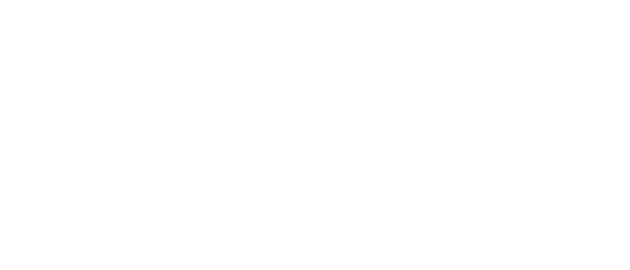

interactive(children=(IntSlider(value=0, description='Time Index', max=99), IntSlider(value=99, description='R…

<function __main__.update_fig(time_idx=0, radius_idx=0)>

In [10]:
# Plot results
%matplotlib notebook

fig_disp, axes_disp = plt.subplots(ncols=3, figsize=(7, 3))
plt.subplots_adjust(wspace=.5)
ax_disp_r = axes_disp[0]
ax_disp_th = axes_disp[1]
ax_disp_phi = axes_disp[2]

def update_fig(time_idx=0, radius_idx=0):
    orbital_period_now_displacement = time_domain[time_idx] / orbital_period
    depth_now_displacement = radii[radius_idx]
    ax_disp_r.clear()
    ax_disp_th.clear()
    ax_disp_phi.clear()
    fig_disp.suptitle(f'{orbital_period_now_displacement:0.2f} Orbital Period; R={depth_now_displacement/1000:0.0f} km')
    
    ax_disp_r.set(ylabel='Latitude [$\deg$]', xlabel='Longitude [$\deg$]',
                  title='Radial Displacement', xlim=(0, 360), ylim=(-90, 90))
    ax_disp_th.set(ylabel='Latitude [$\deg$]', xlabel='Longitude [$\deg$]',
                   title='Polar Displacement', xlim=(0, 360), ylim=(-90, 90))
    ax_disp_phi.set(ylabel='Latitude [$\deg$]', xlabel='Longitude [$\deg$]',
                    title='Azimuthal Displacement', xlim=(0, 360), ylim=(-90, 90))
    
    ax_disp_r.contourf(longitude, latitude, u_r[radius_idx, :, :, time_idx].T, 15)
    ax_disp_th.contourf(longitude, latitude, u_th[radius_idx, :, :, time_idx].T, 15)
    ax_disp_phi.contourf(longitude, latitude, u_phi[radius_idx, :, :, time_idx].T, 15)
    fig_disp.tight_layout()

interact(update_fig,
         time_idx=widgets.IntSlider(min=0, max=len(time_domain)-1, step=1, value=0,
                                    description='Time Index'),
         radius_idx=widgets.IntSlider(min=0, max=len(radii)-1, step=int(len(radii)/20),
                                      value=len(radii)-1, description='Radius Index')
)

## Strain and Stress Tensors
Here we will calculate the strain and stress tensors using the methods described in TB05 and B13

In [11]:
# We need to recast the tidal y solution into the correct dimensions
#    (it does not care about long/lat or time - at least in this context).

strains, stresses = calculate_strain_stress(
    potential, potential_dtheta, potential_dphi, potential_d2theta, potential_d2phi, potential_dtheta_dphi,
    tidal_y, lat_mtx, radii, complex_shears, bulk_modulus_array,
    orbital_freq, order_l=2)

# Strain and stress tensor is stored as a tuple of:
#    s_{rr}, s_{\theta\theta}, s_{\phi\phi}, 2 * s_{r\theta}, 2 * s_{r\phi}, 2 * s_{\theta\phi}
# The two on the cross terms is to account for the matrix being symmetric with twice the number of cross terms.
strain_rr, strain_thth, strain_phph, strain_rth, strain_rph, strain_thph = strains
stress_rr, stress_thth, stress_phph, stress_rth, stress_rph, stress_thph = stresses

### Stress and Strain over time

<IPython.core.display.Javascript object>


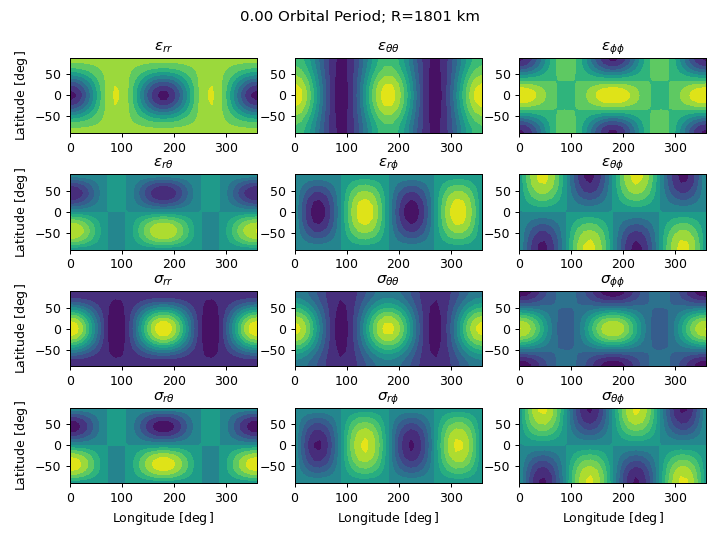

interactive(children=(IntSlider(value=0, description='Time Index', max=99), IntSlider(value=98, description='R…

<function __main__.update_fig(time_idx=0, radius_idx=0, show_imaginary=False)>

In [12]:
%matplotlib notebook

# Plot results
fig_strain_time, axes_stress_strain_time = plt.subplots(ncols=3, nrows=4, figsize=(8, 6))

def update_fig(time_idx=0, radius_idx=0, show_imaginary=False):
    
    orbital_period_now = time_domain[time_idx] / orbital_period
    depth_now = radii[radius_idx]
    
    str_pre = ''
    str_post = ''
    def scale_func(arry):
        return arry
    if show_imaginary:
        str_pre = 'Im['
        str_post = ']'
        def scale_func(arry):
            return np.imag(arry)

    fig_strain_time.suptitle(f'{orbital_period_now:0.2f} Orbital Period; R={depth_now/1000:0.0f} km')
    tensor_txts = {0: 'rr', 1: '\\theta\\theta}', 2: '\\phi\\phi', 3: 'r\\theta', 4: 'r\\phi', 5: '\\theta\\phi'}
    ax_i = 0
    ax_j = 0

    for tensor_i, tensor_txt in tensor_txts.items():

        strain_ax = axes_stress_strain_time[ax_i, ax_j]
        stress_ax = axes_stress_strain_time[2 + ax_i, ax_j]
        strain_ax.clear()
        stress_ax.clear()
        strain_variable = strains[tensor_i][radius_idx, :, :, time_idx]
        stress_variable = stresses[tensor_i][radius_idx, :, :, time_idx]

        if tensor_i in (3, 4, 5):
            # Off diagonal tensor terms are only half counted in the tensor so need to be doubled.
            strain_variable *= 2
            stress_variable *= 2

        strain_ax.contourf(longitude, latitude, scale_func(strain_variable.T), 10)
        stress_ax.contourf(longitude, latitude, scale_func(stress_variable.T), 10)

        if ax_j == 0:
            strain_ax.set(ylabel='Latitude [$\deg$]')
            stress_ax.set(ylabel='Latitude [$\deg$]')
        if ax_i == 1:
            stress_ax.set(xlabel='Longitude [$\deg$]')
        strain_ax.set(title=str_pre+'$\\epsilon_{'+f'{tensor_txt}'+'}$'+str_post, xlim=(0, 360), ylim=(-90, 90))
        stress_ax.set(title=str_pre+'$\\sigma_{'+f'{tensor_txt}'+'}$'+str_post, xlim=(0, 360), ylim=(-90, 90))
        
        ax_j += 1
        if ax_j == 3:
            ax_j = 0
            ax_i += 1
    
    fig_strain_time.tight_layout()
    plt.subplots_adjust(wspace=.2, hspace=0.55)

interact(update_fig, 
         time_idx=widgets.IntSlider(min=0, max=len(time_domain)-1, step=1, value=0, description='Time Index'),
         radius_idx=widgets.IntSlider(min=0, max=len(radii)-1, step=int(len(radii)/20), value=len(radii)-2, description='Radius Index'),
         show_imaginary=False)

### Stress over depth
**Latitude: 0, Longitude: 0**

<IPython.core.display.Javascript object>


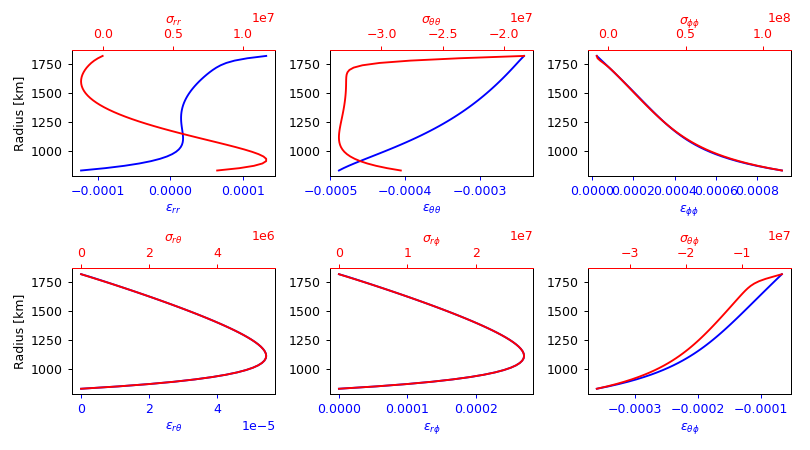

In [13]:
latitude_idx = find_nearest(latitude, 25.)
longitude_idx = find_nearest(longitude, 120.)
time_index = 5

show_real = False
show_imag = False
show_abs = False

# Plot results
fig_strain_depth, axes_strain_depth = plt.subplots(ncols=3, nrows=2, figsize=(9, 5))
plt.subplots_adjust(wspace=.6, hspace=0.5)

def scale_func(arry):
    return arry

str_pre = ''
str_post = ''
if show_real:
    str_pre = 'Re['
    str_post = ']'
    def scale_func(arry):
        return np.real(arry)
elif show_imag:
    str_pre = 'Im['
    str_post = ']'
    def scale_func(arry):
        return np.imag(arry)
elif show_abs:
    str_pre = '|'
    str_post = '|'
    def scale_func(arry):
        return np.abs(arry)

tensor_txts = {0: 'rr', 1: '\\theta\\theta}', 2: '\\phi\\phi', 3: 'r\\theta', 4: 'r\\phi', 5: '\\theta\\phi'}
ax_i = 0
ax_j = 0

for tensor_i, tensor_txt in tensor_txts.items():

    strain_ax = axes_strain_depth[ax_i, ax_j]
    strain_ax.spines['bottom'].set_color('blue')
    strain_ax.xaxis.label.set_color('blue')
    strain_ax.tick_params(axis='x', colors='blue')

    stress_ax = strain_ax.twiny()
    stress_ax.spines['top'].set_color('red')
    stress_ax.xaxis.label.set_color('red')
    stress_ax.tick_params(axis='x', colors='red')

    strain_variable = strains[tensor_i][:, longitude_idx, latitude_idx, time_index]
    stress_variable = stresses[tensor_i][:, longitude_idx, latitude_idx, time_index]

    if tensor_i in (3, 4, 5):
        # Off diagonal tensor terms are only half counted in the tensor so need to be doubled.
        strain_variable *= 2
        stress_variable *= 2

    strain_ax.set(xlabel=str_pre+'$\\epsilon_{'+f'{tensor_txt}'+'}$'+str_post)
    stress_ax.set(xlabel=str_pre+'$\\sigma_{'+f'{tensor_txt}'+'}$'+str_post)
    if ax_j == 0:
        strain_ax.set(ylabel='Radius [km]')

    strain_ax.plot(scale_func(strain_variable), radii / 1000., 'b-')
    stress_ax.plot(scale_func(stress_variable), radii / 1000., 'r-')
    
    ax_j += 1
    if ax_j == 3:
        ax_j = 0
        ax_i += 1
    
fig_strain_depth.tight_layout()
plt.show()

## Tidal Heating Rate


In [14]:
# Calculate tidal heating based on the stress and strain values
# Heating is equal to imag[o] * real[s] - real[o] * imag[s] but we need to multiply by two for the cross terms
#    since it is part of a symmetric matrix but only one side of the matrix is calculated in the previous steps.
# First calculate the trace terms which are not multiply by two.
volumetric_heating = (
        # Im[\sigma_ij] * Re[\epsilon_ij]
            (
                    np.sum(np.imag(stresses[:3]) * np.real(strains[:3]), axis=0) +
                    # Now add the cross terms where we do multiply by two
                    2. * np.sum(np.imag(stresses[:3]) * np.real(strains[:3]), axis=0)
            ) -
            # minus Re[\sigma_ij] * Im[\epsilon_ij]
            (
                    np.sum(np.real(stresses[3:]) * np.imag(strains[3:]), axis=0) +
                    2. * np.sum(np.real(stresses[3:]) * np.imag(strains[3:]), axis=0)
            )
    )
volumetric_heating = np.abs(volumetric_heating)

# The total heating is equal to the volumetric heating times the volume within each voxel.
# TidalPy has an easy function to find these volumes
from TidalPy.utilities.spherical_helper.volume import calculate_voxel_volumes
voxel_volume = calculate_voxel_volumes(radii, longitude_r, colatitude_r)

# Need to increase the dimensions of the voxel volume so that it can be multipled by the heating
#    which is also defined across the time domain.
voxel_volume_higher_dim = voxel_volume[:, :, :, np.newaxis]
heating = volumetric_heating * voxel_volume_higher_dim

# Now lets average the heat across one orbital period
heating_orb_avg = (1. / orbital_period) * np.trapz(heating, time_domain, axis=-1)
volumetric_heating_orb_avg = (1. / orbital_period) * np.trapz(volumetric_heating, time_domain, axis=-1)

<IPython.core.display.Javascript object>


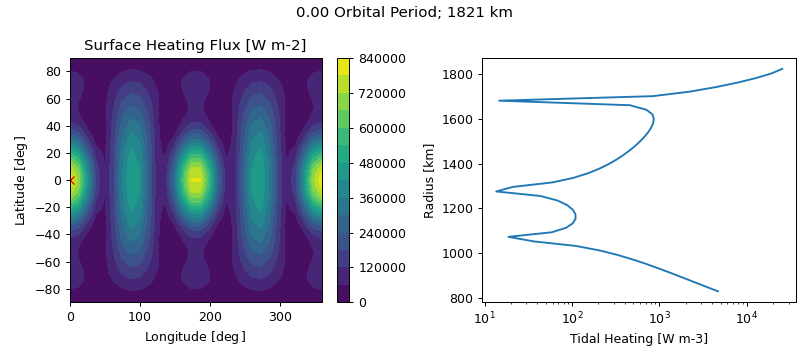

interactive(children=(IntSlider(value=0, description='Time Index', max=99), IntSlider(value=99, description='R…

<function __main__.update_fig(time_idx=0, radius_idx=-1, sum_depth=False, show_flux=True, fixed_long=0.0, fixed_lat=0.0, orbit_average=False)>

In [15]:
# Setup Figure
fig_heat, axes_heat = plt.subplots(ncols=2, figsize=(9, 4))
plt.subplots_adjust(wspace=4, hspace=0.3)

axis_heat = axes_heat[0]
axis_heat_depth = axes_heat[1]

cb_heat = None

def update_fig(time_idx=0, radius_idx=-1,
               sum_depth = False, show_flux = True,
               fixed_long=0., fixed_lat=0., orbit_average=False):

    global cb_heat

    # Determine if we are averaging over the orbit
    if orbit_average:
        heating_to_plot = heating_orb_avg
        heating_at_depth = volumetric_heating_orb_avg
    else:
        heating_to_plot = heating[:, :, :, time_idx]
        heating_at_depth = volumetric_heating[:, :, :, time_idx]

    # Determine if we are summing over the depth of the world
    if sum_depth:
        heating_to_plot = np.nansum(heating_to_plot, axis=0)
    else:
        heating_to_plot = heating_to_plot[radius_idx]

    # Plot Results
    axis_heat.clear()
    axis_heat_depth.clear()
    plt.subplots_adjust(wspace=.1, hspace=0.3)

    # Set figure title
    orbital_period_now = time_domain[time_idx] / orbital_period
    depth_now = radii[radius_idx]
    fig_heat.suptitle(f'{orbital_period_now:0.2f} Orbital Period; {depth_now/1000:0.0f} km')

    if cb_heat is not None:
        cb_heat.remove()
    axis_heat.set(title='Tidal Heating [W]')
    if show_flux:
        if sum_depth:
            heating_to_plot = heating_to_plot / world_surf_area
        else:
            heating_to_plot = heating_to_plot / (4. * np.pi * radii[radius_idx]**2)
        axis_heat.set(title='Surface Heating Flux [W m-2]')
    axis_heat.set(ylabel='Latitude [$\deg$]', xlabel='Longitude [$\deg$]', xlim=(0, 360), ylim=(-90, 90))

    cb_data = axis_heat.contourf(longitude, latitude, heating_to_plot.T, 15)
    cb_heat = plt.colorbar(cb_data, ax=axis_heat)

    # plot depth at sub-stellar point
    lat_indx = find_nearest(latitude, fixed_lat)
    long_indx = find_nearest(longitude, fixed_long)
    axis_heat_depth.plot(heating_at_depth[:, long_indx, lat_indx], radii/1000.)
    axis_heat_depth.set(xlabel='Tidal Heating [W m-3]', ylabel='Radius [km]', xscale='log')

    axis_heat.plot([longitude[long_indx]], [latitude[lat_indx]], marker='x', c='r')

    fig_heat.tight_layout()

interact(update_fig,
         time_idx=widgets.IntSlider(min=0, max=len(time_domain)-1, step=1, value=0, description='Time Index'),
         radius_idx=widgets.IntSlider(min=0, max=len(radii)-1, step=1, value=len(radii)-1, description='Radius Index'),
         sum_depth=widgets.Checkbox(value=False, description='Sum Depths'),
         show_flux=widgets.Checkbox(value=True, description='Heat Flux'),
         orbit_average=widgets.Checkbox(value=False, description='Orbit Averaged'),
         fixed_long=widgets.IntSlider(min=0, max=360, step=30, value=0, description='Fixed $\\phi$'),
         fixed_lat=widgets.IntSlider(min=-90, max=90, step=30, value=0, description='Fixed $\\theta$')
)

## Compare Matrix Propagation vs. Shooting Method

### Radial Function Results

In [ ]:
def shooting_radial(core_static=True, mantle_static=False, incompressible=False):
    core_R = core_radius
    radii = radius_array
    surf_areas = surf_area_array
    volumes = volume_array
    depths = depth_array
    gravitys = gravity_array
    densitys = density_array
    pressures = pressure_array
    viscosities = viscosity_array
    complex_compliances = complex_compliance_array
    complex_shears = complex_shear_array
    shear_moduli = shear_modulus_array
    bulk_moduli = bulk_modulus_array
    
    if incompressible:
        bulk_moduli = 1.0e20 * np.ones_like(bulk_modulus_array)

    if core_static:
        int_rtol=1.0e-10
        int_atol=1.0e-12
    else:
        int_rtol=1.0e-10
        int_atol=1.0e-12
    
    # Use a liquid layer -> solid layer shooting function.
    tidal_y = \
        radial_solver(
            radii, complex_shears, bulk_moduli,
            densitys, gravitys, orbital_freq, world_bulk_density,
            is_solid_by_layer=[False, True], is_static_by_layer=[core_static, mantle_static], indices_by_layer=[core_index, mantle_index],
            order_l=2,
            surface_boundary_condition=None,
            use_kamata=False, verbose=False,
            integrator='numba', integration_method='RK45',
            integration_rtol=1.0e-9, integration_atol=1.0e-10,
            nondimensionalize=True)

    # Calculate parameters not found in the functions above
    k2, h2, l2 = tidal_y[4, :] - 1., tidal_y[0, :] * gravitys, tidal_y[2, :] * gravitys
    
    return tidal_y, (k2, h2, l2)

def prop_matrix_radial():
    core_R = None
    radii = radius_array[mantle_index]
    surf_areas = surf_area_array[mantle_index]
    volumes = volume_array[mantle_index]
    depths = depth_array[mantle_index]
    gravitys = gravity_array[mantle_index]
    densitys = density_array[mantle_index]
    pressures = pressure_array[mantle_index]
    viscosities = viscosity_array[mantle_index]
    complex_compliances = complex_compliance_array[mantle_index]
    complex_shears = complex_shear_array[mantle_index]
    shear_moduli = shear_modulus_array[mantle_index]
    bulk_moduli = bulk_modulus_array[mantle_index]
    
    # Use the propagation matrix technique.
    # Find the fundamental matrix; skip the innermost shell as that will be a boundary condition.
    Y, Y_inv, derivative_mtx = fundamental_matrix_orderl2(radii, complex_shears, densitys, gravitys)

    # Propagate the tidal solution through the world's shells
    central_boundary_condition = np.zeros((6, 3), dtype=np.complex128)
    # Roberts & Nimmo (2008): Liquid innermost zone.
    central_boundary_condition[0, 0] = 0.05 + 0.0j
    central_boundary_condition[1, 1] = 0.01 + 0.0j
    central_boundary_condition[5, 2] = 1.0 + 0.0j

    tidal_y = propagate(Y, Y_inv, derivative_mtx, central_boundary_condition, world_radius, order_l=2)

    # Decompose the tidal solution into useful properties
    #    There is a gradient in this function so we lose another shell. Thus the [1:] in viscoelastic properties
    radial_sensitivity_to_shear, (k2, h2, l2) = \
        decompose(tidal_y, radii, gravitys, complex_shears, bulk_moduli, order_l=2)
    
    return tidal_y, (k2, h2, l2)

shooting_tidal_y, shooting_loves = \
    shooting_radial(incompressible=False)
shooting_tidal_y_incom, shooting_loves_incom = \
    shooting_radial(incompressible=True)
shooting_tidal_y_dynamic, shooting_loves_dynamic = \
    shooting_radial(incompressible=False, core_static=False)
# shooting_tidal_y_dynamic_incom, shooting_loves_dynamic_incom = \
#     shooting_radial(incompressible=True, core_static=False, non_dimensionalize=True)
propmtx_tidal_y, propmtx_loves = \
    prop_matrix_radial()

ys = [shooting_tidal_y, shooting_tidal_y_incom, shooting_tidal_y_dynamic, propmtx_tidal_y]
rs = [radius_array, radius_array, radius_array, radius_array[mantle_index]]
labels = ['Shooting', 'Shooting-Incom', 'Shooting-Dynamic', 'Prop Mtx']
colors = ['yellow', 'green', 'red', 'blue']

fig = yplot(ys, rs, labels=labels, colors=colors)
plt.subplots_adjust(wspace=.5, hspace=0.3)
plt.show()

### Radial Function Performance
Here we will compare the perfomance of prop matrix vs. shooting method. Note this is not a purely apples to apples comparison since we are using wrapping functions and the prop matrix technique is not calculating over the full radial domain. But it will give an order of magnitude estimate

In [20]:
run_performance = True

if run_performance:
    print('Shooting (Static Core)')
    %timeit shooting_radial(incompressible=False)
    print('\nShooting (Static Core; Incompressible)')
    %timeit shooting_radial(incompressible=True)
    print('\nShooting (Dynamic Core)')
    %timeit shooting_radial(incompressible=False, core_static=False)
    print('\nPropagation Matrix')
    %timeit prop_matrix_radial()

Shooting (Static Core)
9.25 ms ± 69.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Shooting (Static Core; Incompressible)
11 ms ± 59.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Shooting (Dynamic Core)
61.4 ms ± 235 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

Propagation Matrix
163 µs ± 844 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
